In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re

from sklearn.metrics import silhouette_score

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import nltk

In [ ]:
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
class clustering:

    def vectorise(self, facts_df):
        # passing in a list with all the processed facts
        vectorizer = CountVectorizer(min_df=5, max_df=0.95, ngram_range=(2, 2))
        matrix = vectorizer.fit_transform(facts_df['Facts'])
        #count_vect = pd.DataFrame(data=matrix.toarray(), columns=vectorizer.get_feature_names_out())
        return vectorizer, matrix

    def tf_idf_vectorizer(self, facts_df):
      # Vectorise
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
        # Matrix rray of vectors that will be used to train the KMeans model (sparse matrix)
        matrix = vectorizer.fit_transform(facts_df['Facts'])

        return vectorizer, matrix

    def calculate_inertia(self, facts_df, end, step):

        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.20, ngram_range=(2,2))
        # Matrix rray of vectors that will be used to train the KMeans model (sparse matrix)
        matrix = vectorizer.fit_transform(facts_df['Facts'])

        inertia_list = []
        for k in range(1,end, step):
          kmeans = KMeans(n_clusters=k, random_state=42)
          kmeans.fit(matrix)
          inertia_list.append(kmeans.inertia_)

        return inertia_list


    def calc_inertia_svd(self, X_svd, end, step):
      inertia_list = []
      for k in range(1,end, step):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_svd)
        inertia_list.append(kmeans.inertia_)

      return inertia_list

    def k_means(self, facts_df, k):

        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.20, ngram_range=(2,2))
        # Matrix rray of vectors that will be used to train the KMeans model (sparse matrix)
        matrix = vectorizer.fit_transform(facts_df['Facts'])

        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(matrix)
        clusters = kmeans.labels_

        # Visualisation
        pca = PCA(n_components=2, random_state=42)
        pca_vecs = pca.fit_transform(matrix.toarray())
        x0 = pca_vecs[:, 0]
        x1 = pca_vecs[:, 1]
        facts_df['Cluster'] = clusters
        facts_df['x0'] = x0
        facts_df['x1'] = x1

        # getting the top keywords
        top_words = pd.DataFrame(matrix.todense()).groupby(clusters).mean()
        terms = vectorizer.get_feature_names_out()
        for i,r in top_words.iterrows():
            print('\nCluster {}'.format(i))
            print(','.join([terms[t] for t in np.argsort(r)[-10:]]))

        cluster_map = {0: 'one', 1: 'two', 2: 'three', 3: 'four', 4:'five', 5: 'six', 6:'seven', 7:'eight'}
        facts_df['Cluster'] = facts_df['Cluster'].map(cluster_map)


        # set image size
        plt.figure(figsize=(12, 7))
        # set a title
        plt.title("TF-IDF + KMeans 20newsgroup clustering", fontdict={"fontsize": 18})
        # set axes names
        plt.xlabel("X0", fontdict={"fontsize": 16})
        plt.ylabel("X1", fontdict={"fontsize": 16})
        # create scatter plot with seaborn, where hue is the class used to group the data
        sns.scatterplot(data=facts_df, x='x0', y='x1', hue='Cluster', palette="Paired")
        plt.show()


In [ ]:
from google.colab import files
import io
uploaded = files.upload()

Saving violation_facts_processed.csv to violation_facts_processed.csv


In [ ]:
all_processed_facts = pd.read_csv(io.BytesIO(uploaded['violation_facts_processed.csv']))

Some preprocessing

In [ ]:
clusters = clustering()

In [ ]:
print(all_processed_facts['Facts'])

0      life warsaw represented gniady practising wars...
1      born serving life prison pärnu prison requeste...
2      born life glina background indicted sisak coun...
3      born detained represented albuga çalıkuşu prac...
4      issue born life weinheim campaign abortion dis...
                             ...                        
202    born life zagreb weekly magazine imperijal pub...
203    born life ankara doctor chairman worker party ...
204    born life focşani material time local correspo...
205    entity russian represented soboleva practising...
206    company limited liability company owner greek ...
Name: Facts, Length: 207, dtype: object


In [ ]:
def remove_lang_words(facts_words, english_words):
  # Filtering out non-english words and three letter words
  filtered = [word for word in facts_words if word in english_words and len(word)>3]
  return filtered

In [ ]:
new_facts = pd.DataFrame(columns=['Facts'])
english_words = set(nltk.corpus.words.words())

for fact in all_processed_facts['Facts']:
  fact_words = fact.split()
  facts_words_filtered = remove_lang_words(fact_words, english_words)
  new_fact = ' '.join(facts_words_filtered)
  new_row = pd.DataFrame({'Facts': [new_fact]})
  new_facts = pd.concat([new_facts, new_row], ignore_index=True)

new_facts.head()

,Facts
0,life warsaw warsaw polish agent ministry forei...
1,born serving life prison prison governor priso...
2,born life background county county charge crim...
3,born agent party professional career involveme...
4,issue born life campaign abortion distributed ...


In [ ]:
len(new_facts)

207

As you can see, we are dealing with about 40k different features. These are all the distinct words found in our corpus (i.e. the collection of our news). We can transform and reduce our input feature space through the Principal Component Analysis (PCA).

Let’s focus on PCA applied by means of the Singular Value Decomposition (SVD). Each component extracted by the decomposition will express a given amount of the variance of our data. In the best case, all the variance is expressed by a low number of new features. The TruncatedSVD class let us decide how many components we want to retain in the new space. Additionally, it provides you the variance those components encode with some inner attributes.

In [ ]:
vectorizer, matrix = clusters.tf_idf_vectorizer(new_facts)

In [ ]:
svd = TruncatedSVD(n_components = 100, random_state = 42)
X_svd = svd.fit_transform(matrix)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.67


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 1.0, 'Calculating Inertia for K Number of Clusters')

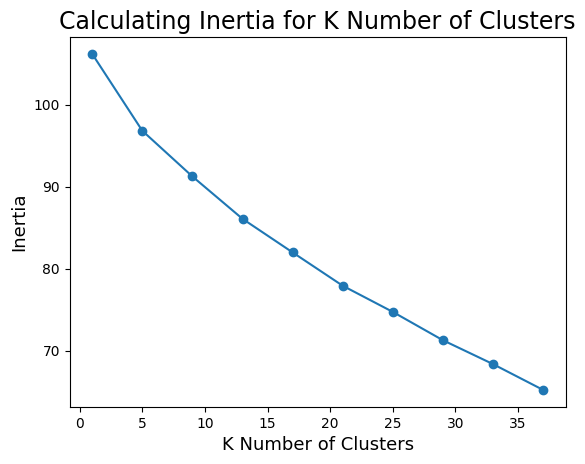

In [ ]:
inertia_list = clusters.calc_inertia_svd(X_svd, 40, 4)
plt.plot(range(1,40, 4),inertia_list)
plt.scatter(range(1,40, 4),inertia_list)
#plt.scatter(3, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("K Number of Clusters", size=13)
plt.ylabel("Inertia", size=13)
plt.title("Calculating Inertia for K Number of Clusters", size=17)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 1.0, 'Different Inertia Values for Different Number of Clusters')

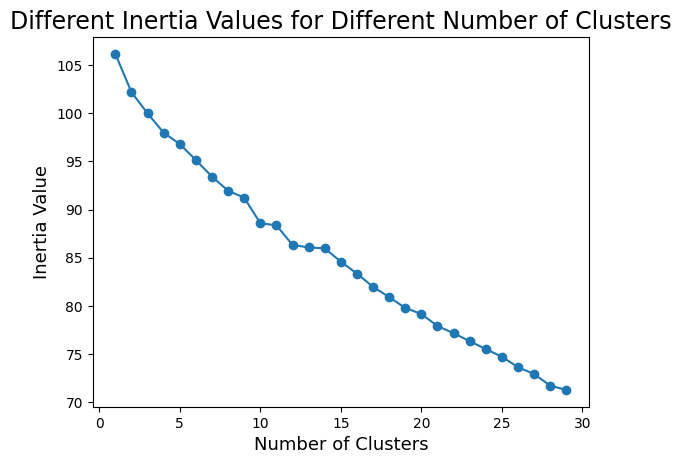

In [ ]:
inertia_list = clusters.calc_inertia_svd(X_svd, 30, 1)
plt.plot(range(1,30, 1),inertia_list)
plt.scatter(range(1,30, 1),inertia_list)
#plt.scatter(3, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia Value", size=13)
plt.title("Different Inertia Values for Different Number of Clusters", size=17)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 1.0, 'Calculating Inertia for K Clusters')

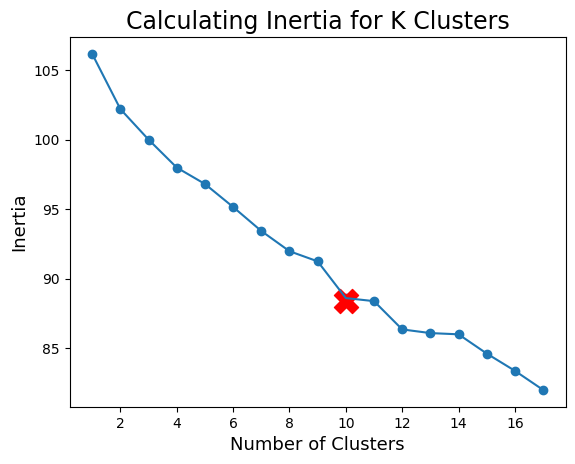

In [ ]:
inertia_list = clusters.calc_inertia_svd(X_svd, 18, 1)
plt.plot(range(1,18, 1),inertia_list)
plt.scatter(range(1,18, 1),inertia_list)
plt.scatter(10, inertia_list[10], marker="X", s=300, c="r")
plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia", size=13)
plt.title("Calculating Inertia for K Clusters", size=17)

We want one clear topic per cluster. An approach to descirbe the clusters would be with word clouds. The more a word is significant the bigger it appears in the picture. Significance measure --> TFIDF

In [ ]:
def word_cloud_generator(X, in_X_tfidf, k, in_word_positions):
  # Clustering
    in_model = KMeans(n_clusters=k, random_state=42)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.show()

    return in_cluster_ids

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.03849411243577884


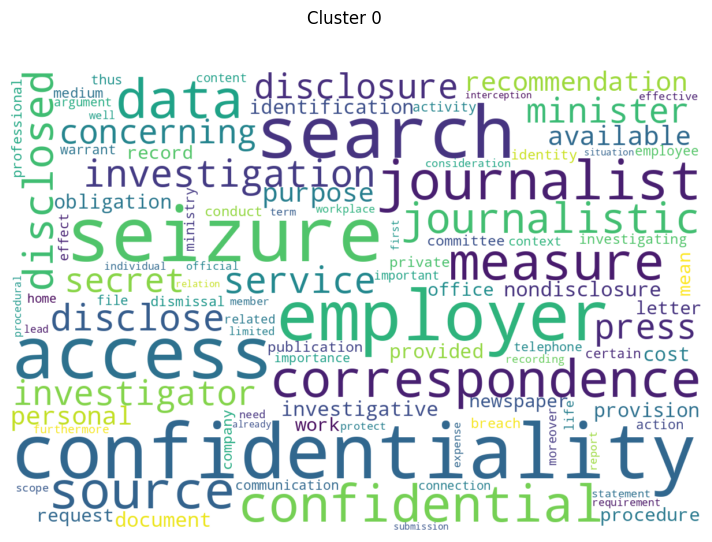

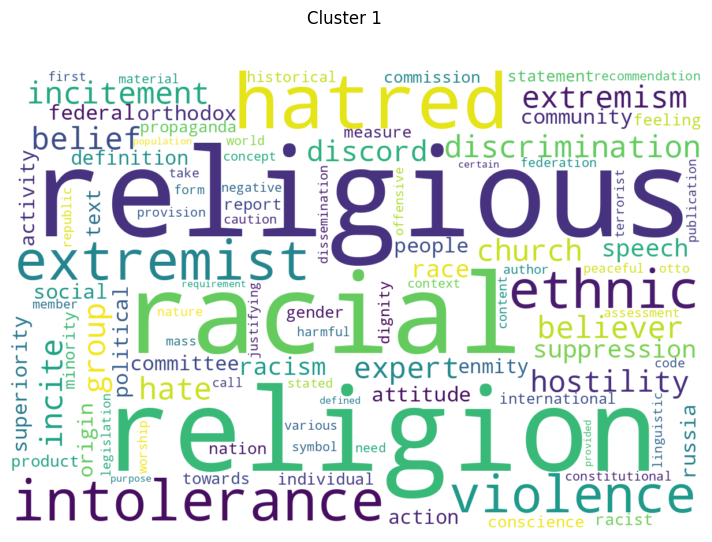

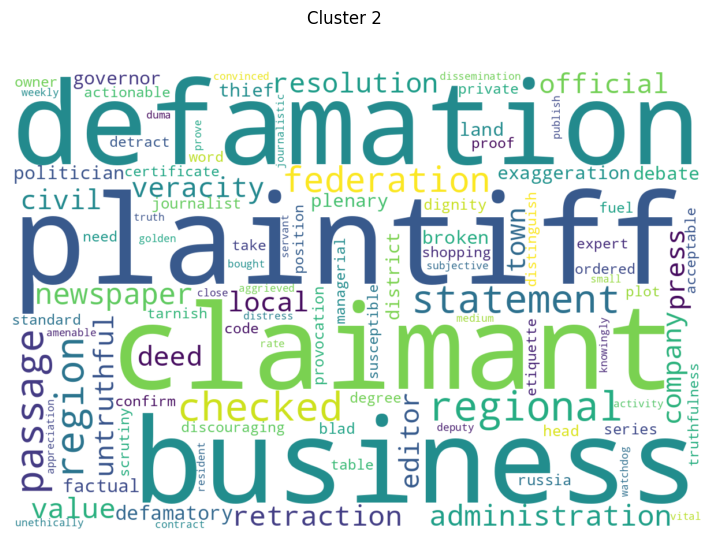

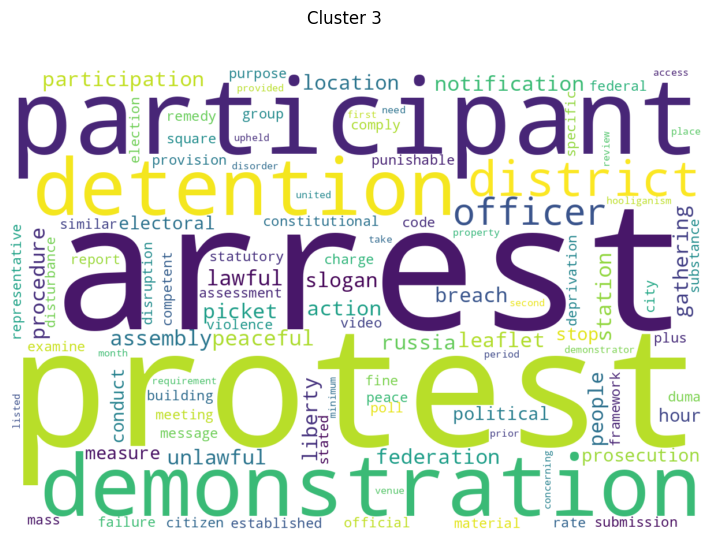

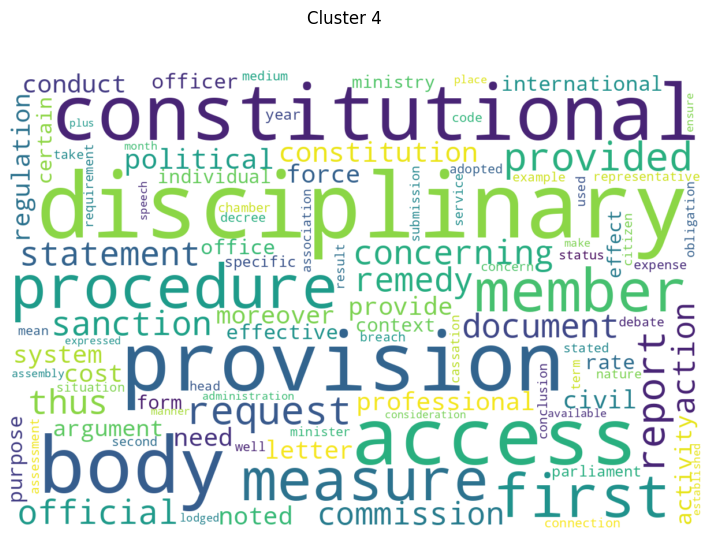

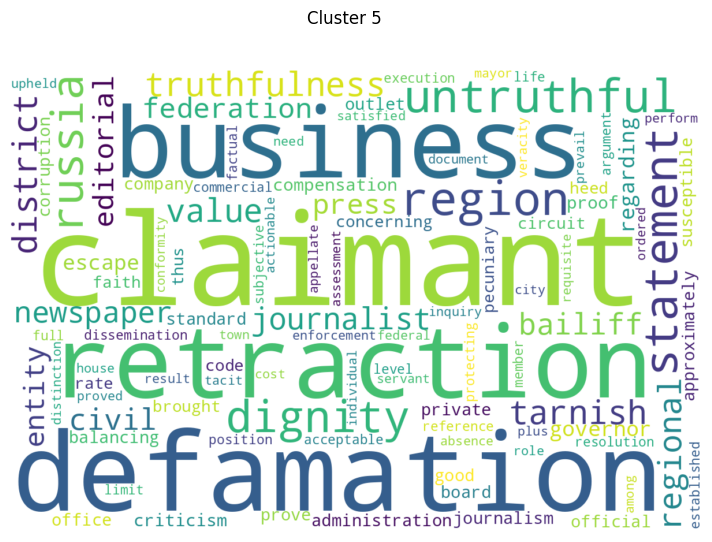

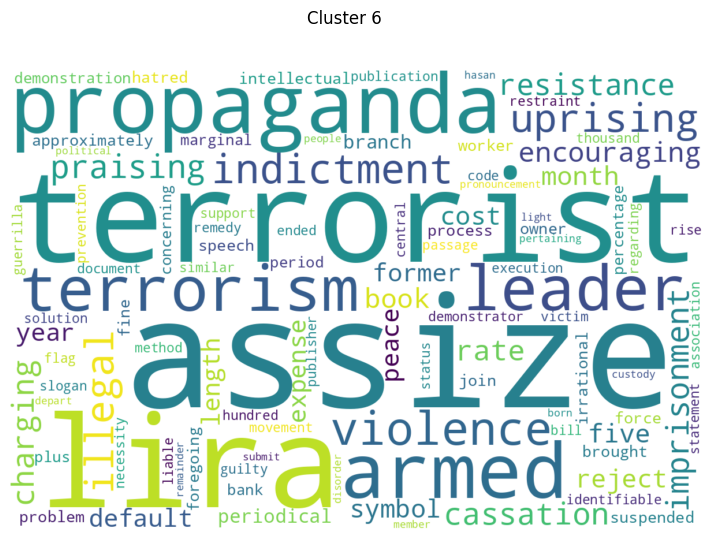

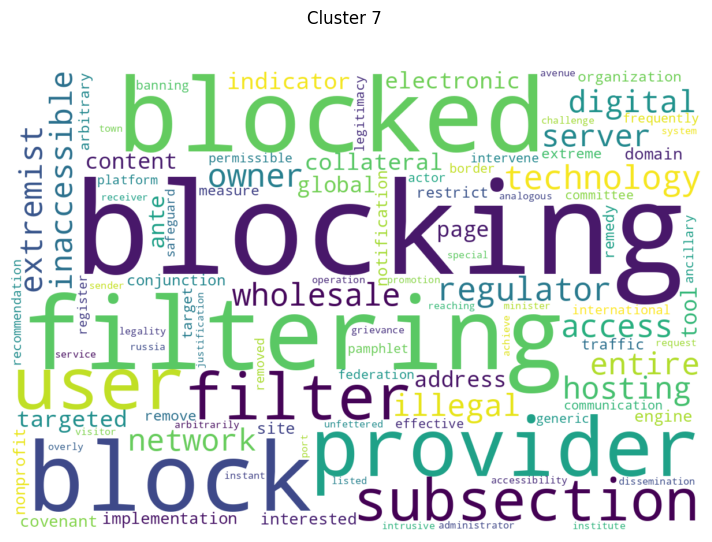

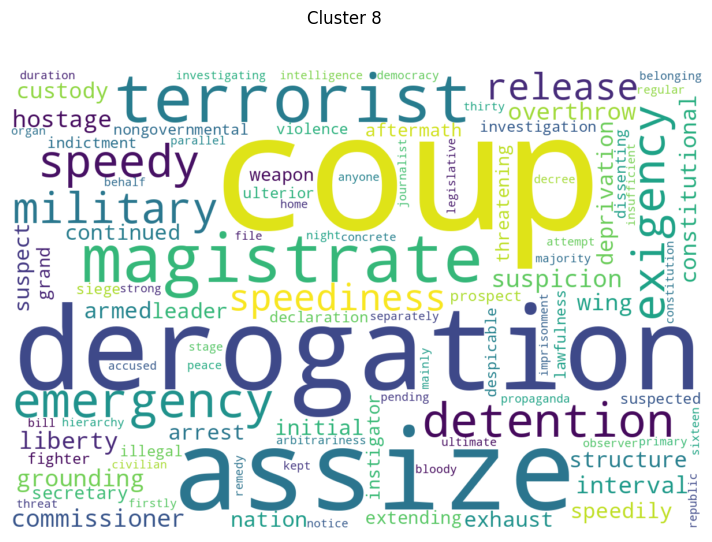

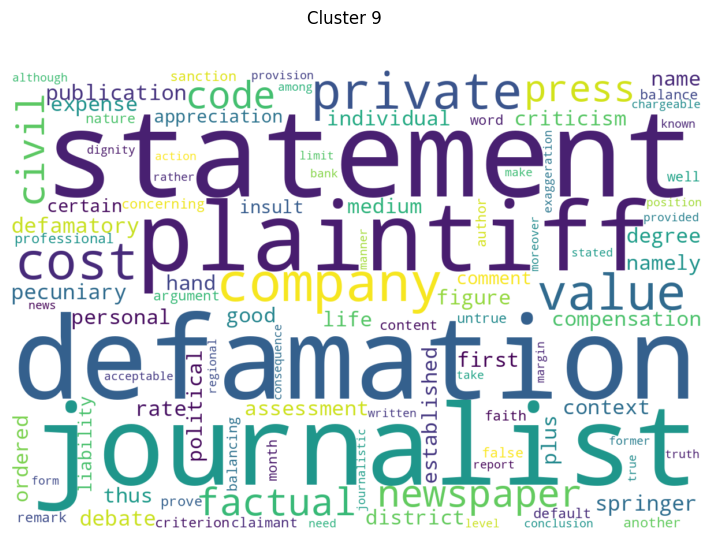

In [ ]:
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_ids = word_cloud_generator(X_svd, matrix, 10, word_positions)

From these results: 8 clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster 0
access content,challenge blocking,domain name,access blocked,service provider,block access,access entire,blocking access,illegal content,blocking measure

Cluster 1
contribution debate,statement amount,personal attack,content form,amount value,amount compensation,basis statement,debate general,good name,truth value

Cluster 2
imposition custodial,form political,violation protocol,conduct question,shall liable,convention substance,within ambit,ambit convention,former code,light foregoing

Cluster 3
draw attention,punishable fine,arrest detention,protest action,submission party,time provided,domestic provision,disciplinary sanction,take part,peaceful assembly

Cluster 4
prove truthfulness,publish retraction,untruthful statement,statement dignity,dissemination statement,dignity professional,professional reputation,resolution plenary,dignity business,business reputation

Cluster 5
interference receive,information interest,refusal provide,information access,request access,provide

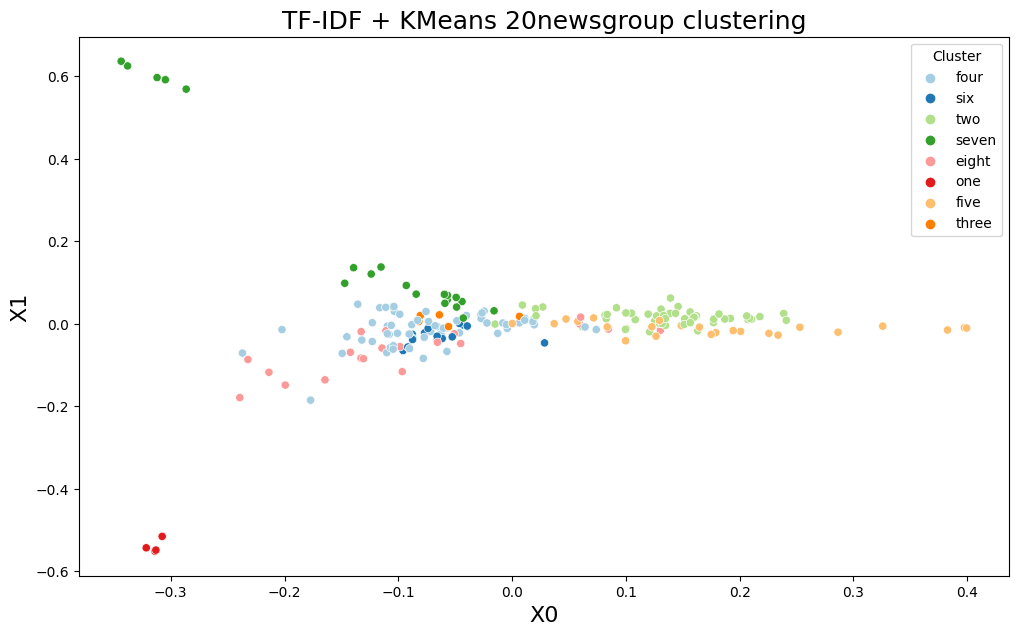

In [ ]:
clusters.k_means(new_facts, 8)

In [ ]:
from google.colab import files
import io
uploaded = files.upload()
all_processed_facts = pd.read_csv(io.BytesIO(uploaded['violation_facts_df_for_cluster.csv']))

Saving violation_facts_df_for_cluster.csv to violation_facts_df_for_cluster.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster 0
company,newspaper,person,plaintiff,claimant,honour,reputation,damage,defamation,statement

Cluster 1
person,state,freedom,authority,information,administrative,decision,section,act,right

Cluster 2
criminal,police,prosecutor,abdullah,propaganda,öcalan,assize,istanbul,kurdish,pkk


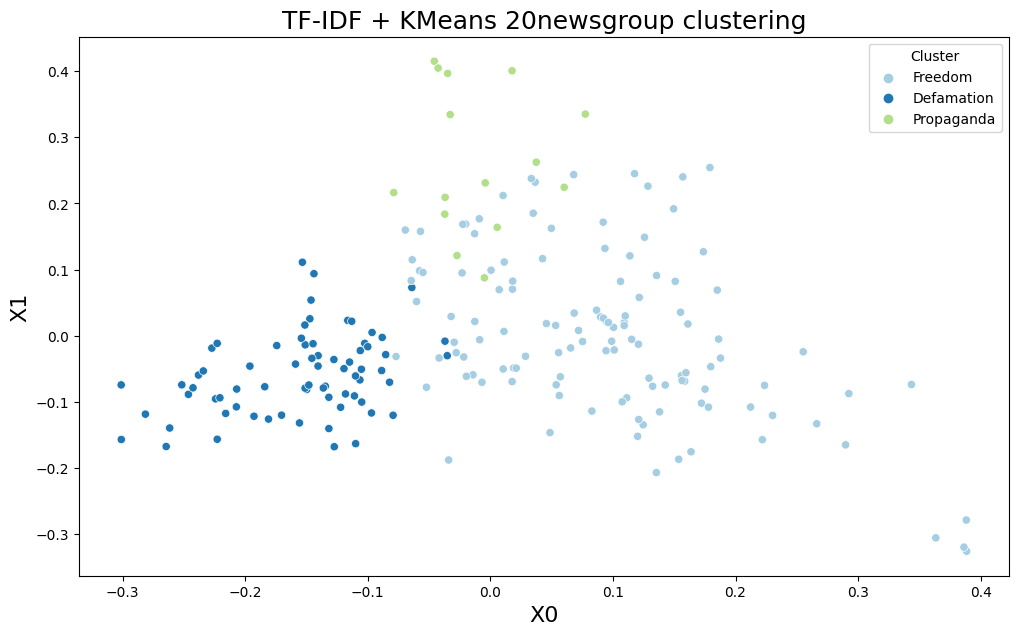

In [ ]:
clusters = clustering()
clusters.k_means(all_processed_facts)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster 0
life istanbul,prevention terrorism,personality right,abdullah öcalan,first instance,terrorist organisation,istanbul state,state security,turkish lira,propaganda favour

Cluster 1
public information,decision taken,private life,disciplinary sanction,act see,от по,committee minister,access information,disciplinary proceeding,official gazette

Cluster 2
religion belief,extremist material,hate speech,suppression extremism,extremism act,religious hatred,ethnic religious,special rapporteur,racial ethnic,extremist activity

Cluster 3
disseminated statement,person disseminated,defamation proceeding,impugned statement,dignity business,damaging honour,professional reputation,article civil,business reputation,honour dignity

Cluster 4
daily newspaper,public figure,publish apology,person concerned,member parliament,pay pln,warsaw regional,article civil,personal right,good name

Cluster 5
police station,others russia,offence article,state duma,event act,district moscow,code administrative

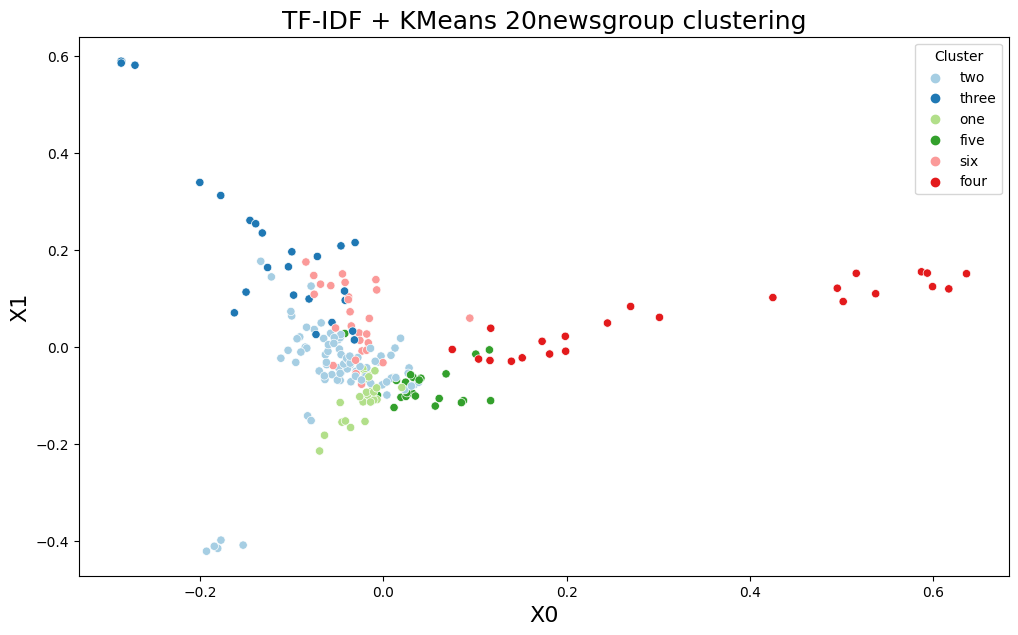

In [ ]:
clusters = clustering()
clusters.k_means(all_processed_facts)